In [28]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from rdkit import Chem

cwd = os.getcwd()
if cwd.endswith('notebook/PG'):
    os.chdir('../..')
    cwd = os.getcwd()

from src.pg_modelling.ligand_utils import sanitize_ligand_name

In [37]:
pg_modelling_folder = Path(os.path.expanduser('~')) / 'Documents' / 'PG_modelling'
data_folder = pg_modelling_folder / 'Human_Lysozyme_C_P61626'
assert data_folder.is_dir()

In [8]:
pg_s_aureu_1mer = pd.read_excel(
    data_folder / 'S_aureus_cell_wall_library.xlsx',
    sheet_name=0,
)
pg_s_aureu_1mer['ligand_id'] = pg_s_aureu_1mer['Name'].apply(sanitize_ligand_name)
pg_s_aureu_1mer = pg_s_aureu_1mer.set_index('ligand_id')
pg_s_aureu_1mer.head()

,Name,Synonym,Formula,Monoisotopic Mass,Modifications,Degree Amidation,Degree Acetylation,Ontology,PGN Units,Glycan Units,...,Peptide,SMILES,INCHIKEY,clogP,RT,[M+H]+,[M+Na]+,[M+K]+,[M+2H]2+,[M+3H]3+
ligand_id,,,,,,,,,,,,,,,,,,,,,
K-3-NH2-GGAGG,None-K[3-NH2-GGAGG],None--Lys[3--NH2--Gly.Gly.Ala.Gly.Gly],C17H31N7O7,445.22850,EPase P2,0,0,P3--S5,1,0,...,K[3-NH2-GGAGG],CC(NC(=O)CNC(=O)CN)C(=O)NCC(=O)NCC(=O)NCCCCC(N...,QTPFCZZQBOJGEK-UHFFFAOYSA-N,-4.5032,0,446.23578,468.21772,484.19166,223.62153,149.41678
qK-3-NH2-GGAGG,None-qK[3-NH2-GGAGG],None--γ-isoGln.Lys[3--NH2--Gly.Gly.Ala.Gly.Gly],C22H39N9O9,573.28707,EPase P1,1,0,P3--S5,1,0,...,qK[3-NH2-GGAGG],CC(NC(=O)CNC(=O)CN)C(=O)NCC(=O)NCC(=O)NCCCCC(N...,JKAQGRXFSWMSGH-UHFFFAOYSA-N,-5.7529,0,574.29435,596.27629,612.25023,287.65082,192.10297
AqK,None-AqK,None--Ala.γ-isoGln.Lys,C14H27N5O5,345.20122,Amidase,1,0,P3,1,0,...,AqK,CC(N)C(=O)NC(CCC(=O)NC(CCCCN)C(=O)O)C(N)=O,ZMNMLXTWGBPAQE-UHFFFAOYSA-N,-2.2177,0,346.20850,368.19044,384.16438,173.60789,116.07435
AqK-3-NH2-GGAGG,None-AqK[3-NH2-GGAGG],None--Ala.γ-isoGln.Lys[3--NH2--Gly.Gly.Ala.Gly...,C25H44N10O10,644.32419,Amidase,1,0,P3--S5,1,0,...,AqK[3-NH2-GGAGG],CC(N)C(=O)NC(CCC(=O)NC(CCCCNC(=O)CNC(=O)CNC(=O...,RPFFOSHAHRWOBP-UHFFFAOYSA-N,-6.2482,0,645.33147,667.31341,683.28735,323.16938,215.78201
AqK-3-NH2-GGSGG,None-AqK[3-NH2-GGSGG],None--Ala.γ-isoGln.Lys[3--NH2--Gly.Gly.Ser.Gly...,C25H44N10O11,660.31910,Amidase,1,0,P3--S5,1,0,...,AqK[3-NH2-GGSGG],CC(N)C(=O)NC(CCC(=O)NC(CCCCNC(=O)CNC(=O)CNC(=O...,MSASYCJULRNIJQ-UHFFFAOYSA-N,-7.2758,0,661.32638,683.30832,699.28226,331.16683,221.11365


In [ ]:
subset_ids = [
    'AqKAA',
    'NAG-NAM',
    'NAG-MUR',
    'NAG-NAM-AqKAA',
    'NAG-MUR-AqKAA',
    'NAG-NAM-AqKAA-3-NH2-GGGGG',
    'NAG-MUR-AqKAA-3-NH2-GGGGG',
]
pg_subset = pg_s_aureu_1mer.loc[subset_ids].rename(columns={
    'SMILES': 'smiles' 
})[['smiles']]
pg_subset
pg_subset.to_csv(data_folder / 'ligands__old.csv')
print(f'N = {len(pg_subset):,}')
pg_subset

N = 7


,smiles
ligand_id,
AqKAA,CC(N)C(=O)NC(CCC(=O)NC(CCCCN)C(=O)NC(C)C(=O)NC...
NAG-NAM,CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)...
NAG-MUR,CC(=O)NC1C(OC2C(CO)OC(O)C(N)C2OC(C)C(=O)O)OC(C...
NAG-NAM-AqKAA,CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)...
NAG-MUR-AqKAA,CC(=O)NC1C(OC2C(CO)OC(O)C(N)C2OC(C)C(=O)NC(C)C...
NAG-NAM-AqKAA-3-NH2-GGGGG,CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)...
NAG-MUR-AqKAA-3-NH2-GGGGG,CC(=O)NC1C(OC2C(CO)OC(O)C(N)C2OC(C)C(=O)NC(C)C...


## Render ligands

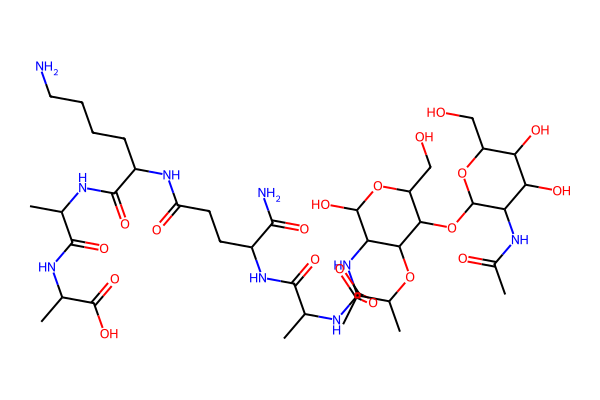

In [10]:
mol = Chem.MolFromSmiles(pg_subset.loc['NAG-NAM-AqKAA', 'smiles'])
img = Chem.Draw.MolToImage(mol, size=(600, 400), dpi=300)
display(img)

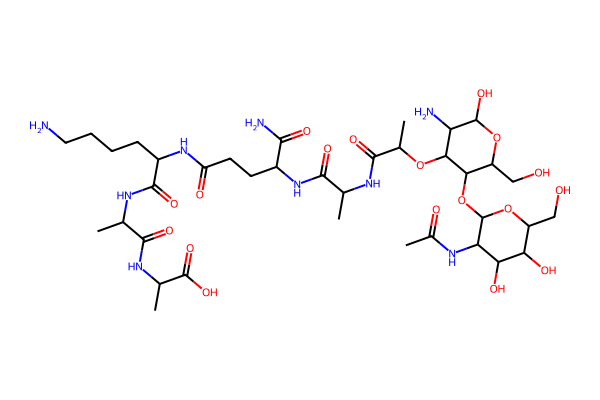

In [11]:
mol = Chem.MolFromSmiles(pg_subset.loc['NAG-MUR-AqKAA', 'smiles'])
img = Chem.Draw.MolToImage(mol, size=(600, 400), dpi=300)
display(img)

## Results

In [30]:
ligand_to_mass = np.log10(pg_s_aureu_1mer.loc[subset_ids]['Monoisotopic Mass'])
ligand_to_mass

ligand_id
AqKAA                        2.687775
NAG-NAM                      2.695648
NAG-MUR                      2.657228
NAG-NAM-AqKAA                2.984732
NAG-MUR-AqKAA                2.965411
NAG-NAM-AqKAA-3-NH2-GGGGG    3.097105
NAG-MUR-AqKAA-3-NH2-GGGGG    3.082265
Name: Monoisotopic Mass, dtype: float64

In [31]:
def sort_and_drop_duplicates(df):
    out_df = df.sort_values(
        [
            'protein_name', 'ligand_name', 'posebusters_score', 'aev_plig_pK', 'confidence',
        ],
        ascending=False,
    ).drop_duplicates(
        ['protein_name', 'ligand_name']
    ).set_index('ligand_name')

    out_df['mass_log'] = [ligand_to_mass[l] for l in out_df.index]
    out_df['aev_plig_pK_norm'] = [
        np.round(out_df.loc[l, 'aev_plig_pK'] / ligand_to_mass[l], 3) for l in out_df.index
    ]

    return out_df.sort_values(
        [
            'posebusters_score', 'aev_plig_pK_norm', 'confidence',
        ],
        ascending=False
    )

### AF3

In [ ]:
af3_results_all = pd.read_csv(data_folder / 'modelling__old' / 'af3' / 'scores.csv')
af3_results = sort_and_drop_duplicates(af3_results_all)
af3_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,mass_log,aev_plig_pK_norm
ligand_name,,,,,,,,,,,,,
AqKAA,Human_Lysozyme_C_P61626,392,0,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.80,0.63,0.664,20,3.0,NaN,5.35,2.687775,1.990
NAG-MUR-AqKAA,Human_Lysozyme_C_P61626,985,4,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.76,0.54,0.584,20,3.9,NaN,5.74,2.965411,1.936
NAG-NAM-AqKAA,Human_Lysozyme_C_P61626,335,1,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.82,0.75,0.764,20,2.4,NaN,5.73,2.984732,1.920
NAG-MUR,Human_Lysozyme_C_P61626,138,3,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.81,0.63,0.666,20,14.7,NaN,5.03,2.657228,1.893
NAG-NAM,Human_Lysozyme_C_P61626,538,4,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.80,0.59,0.632,20,2.8,NaN,5.08,2.695648,1.885
NAG-MUR-AqKAA-3-NH2-GGGGG,Human_Lysozyme_C_P61626,85,0,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.73,0.50,0.546,20,25.9,NaN,5.72,3.082265,1.856
NAG-NAM-AqKAA-3-NH2-GGGGG,Human_Lysozyme_C_P61626,589,0,/home/rs1521/PG/Human_Lysozyme_C_P61626/modell...,0.71,0.49,0.534,20,3.0,NaN,5.72,3.097105,1.847


### Boltz

In [36]:
boltz_results_all = pd.read_csv(data_folder / 'modelling__old' / 'boltz' / 'scores.csv')
boltz_results = sort_and_drop_duplicates(boltz_results_all)
boltz_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,mass_log,aev_plig_pK_norm
ligand_name,,,,,,,,,,,,,
NAG-MUR-AqKAA,Human_Lysozyme_C_P61626,934,2,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.760974,0.476656,0.534,20,4.0,NaN,5.80,2.965411,1.956
NAG-NAM,Human_Lysozyme_C_P61626,934,2,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.844275,0.713644,0.740,20,2.2,NaN,5.25,2.695648,1.948
NAG-MUR,Human_Lysozyme_C_P61626,538,0,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.866804,0.825844,0.834,20,3.2,NaN,5.15,2.657228,1.938
NAG-NAM-AqKAA-3-NH2-GGGGG,Human_Lysozyme_C_P61626,934,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.764059,0.560568,0.601,20,7.5,NaN,5.77,3.097105,1.863
AqKAA,Human_Lysozyme_C_P61626,85,4,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.785890,0.401144,0.478,20,4.9,NaN,4.99,2.687775,1.857
NAG-MUR-AqKAA-3-NH2-GGGGG,Human_Lysozyme_C_P61626,934,0,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.740494,0.492747,0.542,20,3.7,NaN,5.72,3.082265,1.856
NAG-NAM-AqKAA,Human_Lysozyme_C_P61626,934,0,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.808441,0.649224,0.681,19,5.0,minimum_distance_to_protein,5.94,2.984732,1.990


### Chai

In [ ]:
chai_results_all = pd.read_csv(data_folder / 'modelling__old' / 'chai' / 'scores.csv')
chai_results = sort_and_drop_duplicates(chai_results_all)
chai_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,mass_log,aev_plig_pK_norm
ligand_name,,,,,,,,,,,,,
AqKAA,Human_Lysozyme_C_P61626,536,3,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.913931,0.559628,0.630,20,7.9,NaN,5.19,2.687775,1.931
NAG-NAM-AqKAA,Human_Lysozyme_C_P61626,95,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.884068,0.636099,0.686,20,2.8,NaN,5.76,2.984732,1.930
NAG-MUR,Human_Lysozyme_C_P61626,95,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.916966,0.611582,0.673,20,1.9,NaN,5.09,2.657228,1.916
NAG-MUR-AqKAA,Human_Lysozyme_C_P61626,95,4,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.879158,0.598352,0.655,20,2.9,NaN,5.63,2.965411,1.899
NAG-NAM,Human_Lysozyme_C_P61626,536,3,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.919270,0.720598,0.760,20,2.7,NaN,5.06,2.695648,1.877
NAG-MUR-AqKAA-3-NH2-GGGGG,Human_Lysozyme_C_P61626,536,2,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.826708,0.521293,0.582,20,2.7,NaN,5.76,3.082265,1.869
NAG-NAM-AqKAA-3-NH2-GGGGG,Human_Lysozyme_C_P61626,118,4,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.830443,0.521342,0.583,20,2.3,NaN,5.72,3.097105,1.847


### Protenix

In [ ]:
protenix_results_all = pd.read_csv(data_folder / 'modelling__old' / 'protenix' / 'scores.csv')
protenix_results = sort_and_drop_duplicates(protenix_results_all)
protenix_results

,protein_name,seed,sample,structure_file,ptm,iptm,confidence,posebusters_score,energy_ratio,posebusters_errors,aev_plig_pK,mass_log,aev_plig_pK_norm
ligand_name,,,,,,,,,,,,,
NAG-NAM-AqKAA,Human_Lysozyme_C_P61626,117,2,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.965438,0.972745,0.971,20,3.8,NaN,5.91,2.984732,1.980
NAG-MUR-AqKAA,Human_Lysozyme_C_P61626,105,0,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.958434,0.969455,0.967,20,3.4,NaN,5.86,2.965411,1.976
AqKAA,Human_Lysozyme_C_P61626,117,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.970027,0.976795,0.975,20,3.4,NaN,5.28,2.687775,1.964
NAG-MUR,Human_Lysozyme_C_P61626,105,3,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.957023,0.977773,0.974,20,4.6,NaN,4.99,2.657228,1.878
NAG-MUR-AqKAA-3-NH2-GGGGG,Human_Lysozyme_C_P61626,105,3,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.958039,0.946739,0.949,20,3.9,NaN,5.75,3.082265,1.866
NAG-NAM-AqKAA-3-NH2-GGGGG,Human_Lysozyme_C_P61626,117,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.957655,0.960162,0.960,20,5.9,NaN,5.76,3.097105,1.860
NAG-NAM,Human_Lysozyme_C_P61626,117,1,/gpfs/home/rs1521/PG/Human_Lysozyme_C_P61626/m...,0.957687,0.963509,0.962,20,4.3,NaN,4.91,2.695648,1.821


## Revisited: use negative controls

- NAG-NAM-sidechain from S. aureus (positive control)
- NAG-NAM-sidechain from E. coli (positive control)
- G-MUR-sidechain from S. aureus (negative control)
- G-MUR-sidechain from E. coli (negative control)
- Any odd lipid in the same molecular weight ballpark (negative control)

In [40]:
E_coli_libary = pg_modelling_folder / 'PG_library' / 'Escherichia_coli' / 'E_coli_cell_wall_library.xlsx'
S_aureus_libary = pg_modelling_folder / 'PG_library' / 'Staphylococcus_aureus' / 'S_aureus_cell_wall_library.xlsx'

pg_library = pd.concat(
    [
        pd.read_excel(
            E_coli_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            E_coli_libary,
            sheet_name=1,
        ),
        pd.read_excel(
            S_aureus_libary,
            sheet_name=0,
        ),
        pd.read_excel(
            S_aureus_libary,
            sheet_name=1,
        ),
    ],
    ignore_index=True,
)
pg_library['ligand_id'] = pg_library['Name'].apply(sanitize_ligand_name)
pg_library = pg_library.drop_duplicates('ligand_id')
pg_library = pg_library.set_index('ligand_id')
print(f'N = {len(pg_library):,}')

N = 2,089


In [41]:
subset_ids = [
    'NAG-NAM-AqKA',
    'G-MUR-AqKA',
    'NAG-NAM-AemA',
    'G-MUR-AemA',
]
pg_library_subset = pg_library.loc[subset_ids].rename(columns={
    'SMILES': 'smiles' 
})[['smiles']]
print(f'N = {len(pg_library_subset):,}')
pg_library_subset

N = 4


,smiles
ligand_id,
NAG-NAM-AqKA,CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)...
G-MUR-AqKA,CC(NC(=O)C(CCCCN)NC(=O)CCC(NC(=O)C(C)NC(=O)C(C...
NAG-NAM-AemA,CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)...
G-MUR-AemA,CC(NC(=O)C(CCCC(N)C(=O)O)NC(=O)CCC(NC(=O)C(C)N...


In [51]:
# Pick larg-ish lipid from E. coli: (3S)-citryl-CoA
lipid_maps = pd.read_csv(pg_modelling_folder / 'PG_library' / 'lipid_maps' / 'lipids.csv')
lipid_df = lipid_maps[lipid_maps['NAME'] == '(3S)-citryl-CoA'].copy()
lipid_df['ligand_id'] = lipid_df['NAME'].apply(lambda n: f'lipid-{sanitize_ligand_name(n)}')
lipid_df = lipid_df.set_index('ligand_id').rename(columns={
    'SMILES': 'smiles' 
})[['smiles']]

ligands_df = pd.concat([pg_library_subset, lipid_df])
ligands_df.to_csv(data_folder / 'ligands.csv')
print(f'N = {len(ligands_df):,}')
ligands_df

N = 5


,smiles
ligand_id,
NAG-NAM-AqKA,CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)...
G-MUR-AqKA,CC(NC(=O)C(CCCCN)NC(=O)CCC(NC(=O)C(C)NC(=O)C(C...
NAG-NAM-AemA,CC(=O)NC1C(OC2C(CO)OC(O)C(NC(C)=O)C2OC(C)C(=O)...
G-MUR-AemA,CC(NC(=O)C(CCCC(N)C(=O)O)NC(=O)CCC(NC(=O)C(C)N...
lipid-3S-citryl-CoA,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...
